In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm

from src.material_model import LinearElasticityPerfectPlasticity as LEPP
from src.sampler import MetropolisHastings, AdaptiveMetropolisHastings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

## Generic functions

In [2]:
def add_labels(graph_title, x_label, y_label):
    """
    Add labels to graphs
    """
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

# Linear Elasticity-Perfect Plasticity

## Parameters

A linear elastic-perfectly plastic specimen is considered with Young's modulus $E =$ 210 GPa and yield stress $\sigma_{y0} =$ 0.25 GPa. 

The parameters to be identified (inferred) for the linear elastic-perfectly plastic model are the Young's modulus $E$ and the initial yield stress $\sigma_{y0}$, which are stored in the parameter vector $\textbf{x}$:

 $$\textbf{x}=[E \; \sigma_{y0}]^T$$

In [3]:
E = 210           # Young's modulus (GPa)
stress_y = 0.25   # Yield stress (GPa)
s_noise = 0.01    # Noise in the stress measurement (GPa)

## Constitutive model

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0}]^T$$

$E$ is the Young's modulus and $\sigma_{y0}$ is the initial yield stress.

### Stress-strain graph

Twelve experimental measurements are provided. The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$.

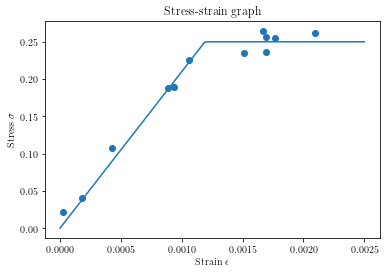

In [4]:
model = LEPP(E, stress_y, s_noise)
strain = np.linspace(0, 2.5E-3, 100)
model.stress_strain_response(strain)
strain_data, stress_data = model.generate_synthetic_data(strain, 12)
plt.scatter(strain_data, stress_data);

## Likelihood $\pi(y|\textbf{x})$

The likelihood function for a single stress measurement is given by the following equation

$$\pi(y|\textbf{x}) = \pi_{noise}(y - \sigma(\epsilon, \textbf{x})) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - \sigma(\epsilon, \textbf{x})\right)^2}{2s^2_{noise}}}\right)$$

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior $\pi(\textbf{x})$

Choosing the prior distribution in the form of a modified normal distribution:

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector (prior candidate vector) and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 \\ 0 & 2.7778 \times 10^{-4} \end{bmatrix} \; \text{GPa}^2$$

In [5]:
x_prior = np.array([[200], [0.29]])                       # Mean vector (GPa)
cov_matrix_prior = np.array([[2500, 0], [0, 2.7778E-4]])  # Covariance matrix (GPa^2)
model.set_priors(x_prior, cov_matrix_prior)

## Posterior

The posterior distribution for a single stress measurement is given by the following equation:

$$\pi(\textbf{x}|y) \propto \pi(\textbf{x})\pi(y|\textbf{x}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

If we now consider the posterior distribution of the previous measurement to be the prior distribution of the current measurement, the posterior for all $n_m$ measurements can be expressed as:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x})) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, $y_i$ is the measured stress and $\epsilon_i$ is the measured strain.

In [6]:
x_candidate = np.array([[210], [0.25]])
print(model.posterior(strain_data, stress_data, x_candidate))

x_candidate = np.array([[200], [0.29]])
print(model.posterior(strain_data, stress_data, x_candidate))

[[5.72701475e+14]]
[[6.34097729e-05]]


## The standard Metropolis-Hastings algorithm

The standard Metropolis-Hastings approach is a frequently employed MCMC algorithm. The basic idea of the Metropolis-Hastings algorithm is to explore the probability density function (PDF) of interest by making a random walk through the parameter space $\textbf{x}$.

### Proposal distribution

Consider sample $\textbf{x}_i$ and its evaluation of the PDF, $\pi(\textbf{x}_i)$ new sample $\textbf{x}_p$ is proposed by drawing from a proposal distribution.

$$q(\textbf{x}_i | \textbf{x}_p) = q(\textbf{x}_p | \textbf{x}_i) \propto exp\left(-\frac{1}{2\gamma^2}\|\textbf{x}_i - \textbf{x}_p\|^2\right)$$

$\gamma$ denotes the parameter that determines the width of the proposal distribution and must be tuned to obtain an efficient and converging algorithm. An efficient starting value is given by the following equation [1]:

$$\gamma = \frac{2.38}{\sqrt{n_p}}$$

Where $n_p$ denotes the number of unknown parameters.

[1] Gelman A, Roberts GO, Gilks WR (1996) Efficient Metropolis jumping rules. In: Bernardo JM, Berger JO, Dawid AP, Smith AFM (eds) Bayesian Statistics, vol 5. Oxford University Press, pp 599-607



New sample $\textbf{x}_p$ is proposed by drawing from a proposal distribution $q(\textbf{x}_i | \textbf{x}_p)$... << is this correct?

In the case of a symmetric proposal distribution (as in this example), the following relation holds:

$$q(\textbf{x}_i | \textbf{x}_p) = q(\textbf{x}_p | \textbf{x}_i)$$

## Markov Chain Monte Carlo

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$

In [7]:
data = [strain_data, stress_data]
mh = MetropolisHastings(model, data, n_samples=1E5)

x_0 = np.array([[200], [0.29]])  # Initial sample
x_hist, pdf_hist = mh.sample(x_0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3510.02it/s]


The chain is run for 1E5 samples and the first 3000 samples are burnt (i.e. the first 3000 samples are not used to determine the mean, the covariance matrix and the MAP estimate).

In [8]:
x_mean = mh.calculate_mean(x_hist)
print(x_mean)

[210.99450012   0.25313028]


In [9]:
x_cov = mh.calculate_covariance(x_hist)
print(x_cov)

[[6.82586443e+01 6.07615492e-03]
 [6.07615492e-03 1.56812562e-05]]


### Visualise the proposal distribution

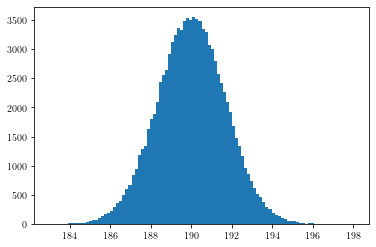

In [10]:
n_samples = 100000
x_i = ([190], [0.2])
x_p = np.zeros([n_samples, np.size(x_i)])

for i in range(n_samples):
    x_p[i, :] = np.transpose(mh.draw_proposal(x_i))

plt.hist(x_p[:, 0], 100);

### Convergence

A commonly employed approach to check the stability and convergence of the scheme is to trace the generated samples and analyse their characteristics.

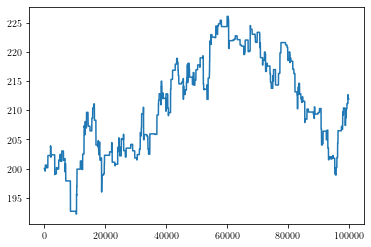

In [11]:
plt.plot(x_hist[:, 0])

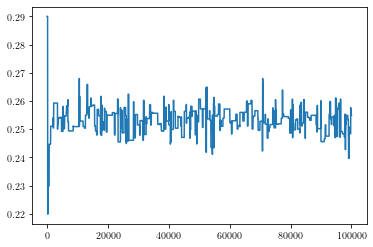

In [12]:
plt.plot(x_hist[:, 1])

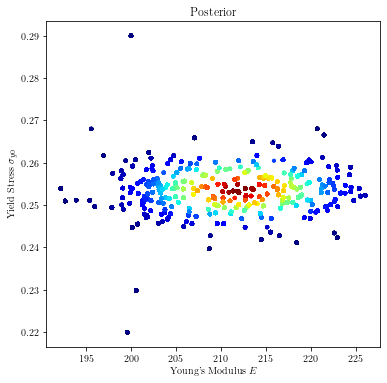

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x_hist[:,0], x_hist[:,1], s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
fig.savefig('posterior.png', dpi=300) 

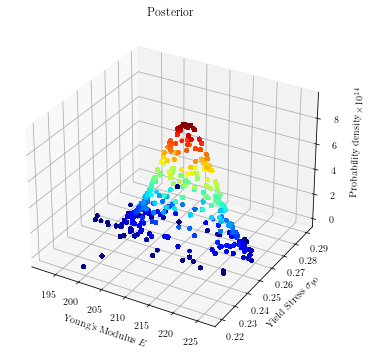

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_hist[:,0], x_hist[:,1], pdf_hist, s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel('Probability density');

## The Adaptive Metropolis-Hastings algorithm


The width of the proposal distribution $\gamma$ has to be tuned to obtain an efficient and converging algorithm. It can be seen in the above figures that the chain converges on the correct yield stress $\sigma_{y0}$ but poor convergence behaviour is observed for the Young's modulus $E$. To overcome the tuning of $\gamma$, Haario et al. [2] introduced the adaptive proposal (AP) method. The AP method updates the width of the proposal distribution using the existing knowledge of the posterior. The existing knowledge is based on the previous samples.

For sample $n_k + 1$, the update employs the following formulation:

$$q(\textbf{x}_p | \textbf{x}_i) \sim \mathcal{N}(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$$

Where $\mathcal{N}(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$ denotes a normal distribution with mean $\textbf{x}_i$ and covariance matrix $\gamma^2 \textbf{R}_{n_{\textbf{k}}}$ of size $n_p \times n_p$. To establish $\textbf{R}_{n_{\textbf{k}}}$, all $n_k$ previous samples are first stored in matrix $\textbf{K}$ of size $n_{\textbf{K}} \times n_p$. $\textbf{R}_{n_{\textbf{k}}}$ is then computed as:

$$\textbf{R}_{n_{\textbf{k}}} = \frac{1}{n_{\textbf{K}} - 1}\tilde{\textbf{K}}^T\tilde{\textbf{K}}$$

Where $\tilde{\textbf{K}} = \textbf{K} - \textbf{K}_{mean}$ and $\textbf{K}_{mean}$ reads:

$$\textbf{K}_{mean} =
\begin{bmatrix}
   \textbf{k}_{mean} \\
   \textbf{k}_{mean}  \\
   \vdots \\
   \textbf{k}_{mean} 
\end{bmatrix}_{\: n_\textbf{K} \, \times \, n_p}
$$

and $\textbf{K}_{mean}$ denotes a row matrix (vector?) of length $n_p$ (number of unknow parameters) which is determined as follows:

$$\textbf{k}_{mean} = \frac{1}{i}\begin{bmatrix} \sum_{i=1}^{n_\textbf{K}} (K)_{i1} & \sum_{i=1}^{n_\textbf{K}} (K)_{i2} & \cdots & \sum_{i=1}^{n_\textbf{K}} (K)_{in_p} \end{bmatrix}$$

The following relation is used for $\mathcal{N}(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$ in this contribution:


[2] Haario, H., Saksman, E., & Tamminen, J. (1999). Adaptive proposal distribution for random walk Metropolis algorithm. Computational Statistics, 14(3), 375-395.

In [15]:
data = [strain_data, stress_data]
mh_ap = AdaptiveMetropolisHastings(model, data, n_samples=1E5)

x_0 = np.array([[200], [0.29]])  # Initial sample
x_hist, pdf_hist = mh_ap.sample(x_0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3532.61it/s]


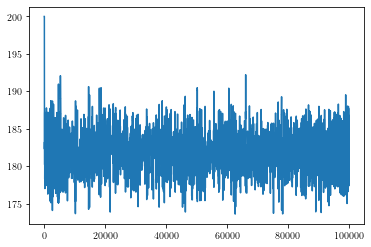

In [16]:
plt.plot(x_hist[:, 0])

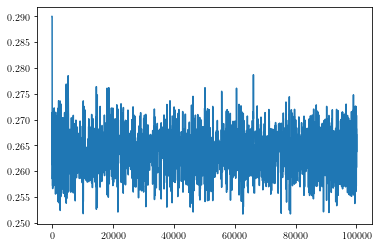

In [17]:
plt.plot(x_hist[:, 1])

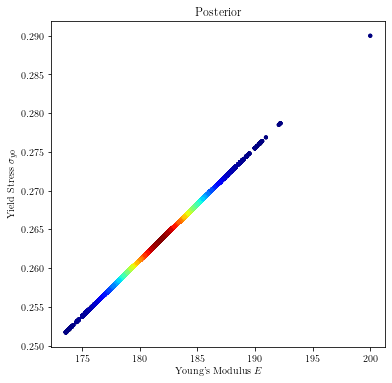

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x_hist[:,0], x_hist[:,1], s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
fig.savefig('posterior.png', dpi=300) 

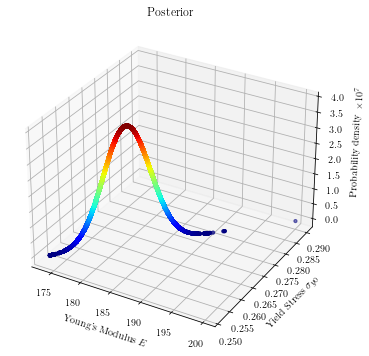

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_hist[:,0], x_hist[:,1], pdf_hist, s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel('Probability density');